<a href="https://colab.research.google.com/github/Antony-gitau/probabilistic_AI_playgraound/blob/main/Variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes:

Generative models aim to learn the probability density function $p(x)$ 
 (distribution probability) that best describes the training data to enable generation by sampling from the distribution.

 - sample generation: 
 - density estimation:

different strategy to achieve this goal:
1. explicit density model - 
2. implicit density model - 

latent variable models:
1. variational autoencoder
2. Generative Adversarial Network

**Autoencoder**

- unsupervised learning approach
- dimensionality of latent space 
- representation learning 
- self encoding or auto-encoding

**variational autoencoder**
- probability twist on autoencoder
- loss function: 
encoder: f



generation is the process of computing a data point $x$ from the latent variable $z$. 

maximum likelihood of the mean or standard deviation - estimation technique for parameters of a probability distribution so that the distribution fits the observed data. 


likelihood - finding the optimal values for the mean (or standard deviation) for a distribution given a bunch of observed measurements.

approximation methods:
1. markov chain monte carlo
2. variational inference


amortized variational inference - train an external neural network to predict the variational parameters instead of optimizing ELBO per data point.

reparametarization - rewriting the the expectation so that the distribution is independent of the parameter $Θ$

**GAN**
- conditional GAN
- CycleGAN

**Diffusion models**

[good read](https://theaisummer.com/latent-variable-models/)

[mit lecture](https://youtu.be/3G5hWM6jqPk?list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI)

In this notebook we will go into details on Variational Autoencoder with inspiration from [MIT'S Lab 2 on face detection](https://colab.research.google.com/drive/1j2W42n7R2DeBuO0xQZr7kDmTY2Z4Sexw#scrollTo=nLemS7dqECsI)

![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg) this is the architectural design of a Variational Autoencoder (VAE).

**encoder** transform inputs into variables, for example defined by mean and standard deviation, then draw from that distribution (defined by the mean and standard deviation) to generate a set of sampled latent variables.

**decoder** the decoder's task is to reconstruct the latent variable to the original form of the input data. The decoder learns which latent variables are important. 

**goal of VAE** is therefore to train a model that learns a representation of the underlying latent space of the training data.

**Loss function** 
- the encoder needs to learn latent variables which should ideally match the input (remember the input is transformed into a unit gaussian). this is the latent loss.

- the decoder needs to reconstruct the latent variables clossly to the input. this is reconstruction loss.

- so the total loss of a variational autoencoder is the sum of latent and reconstruction loss.


In [27]:
import tensorflow as tf

In [49]:
def vae_loss_function(x, x_reconstructed, mu, logsigma, kl_weight = 0.005):
  '''
  we pass an input and its reconstruction.
  we also define the prior distribution with mean and log of standard deviation
  kl_weight is the weight parameter for the latent loss used for regularization
  '''
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) -1.0 - logsigma, axis=-1)
  abs_diff = tf.abs(x - x_reconstructed)
  reconstruction_loss = tf.reduce_mean(abs_diff, axis=[1,2,3])
  vae_loss = kl_weight * latent_loss + reconstruction_loss

  return vae_loss

Sampling and reparameterization

In [50]:
def sampling(z_mean, z_logsigma):
  '''
  we pass the mean and logarithm of variance of the learned latent variable
  we extracts the batch size and the number of dimensions in the latent space
  we then generate random samples from a standard normal distribution 
  the shape of the random sample is the same as the mean of latent variables
  we compute the parameterization trick
  '''
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape = (batch, latent_dim))
  z = z_mean  + tf.math.exp(0.5 * z_logsigma) * epsilon

  return z



Semi-supervised variational autoencoder (SS-VAE)

- the motivation is to use variational encoder to uncover bias in face recognition. 
- notice there is a supervised classification problem.
- notice also that the VAE we talked about earlier did not output supervised variables.

- lets workout a loss function

In [51]:
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  '''
  we pass an input, x, and its reconstruction, x_pred
  we then pass a true label, y, and its prediction, y_logit
  y_logits are the raw output before applying sigmoid function
  we then pass the mean and log standard deviation of the learned latent distribution
  '''
  # we call the vae_loss function we defined earlier
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  
  # we then define classification loss 
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  #classification_loss = tf.reduce_mean(classification_loss)

  # we create an indicator for which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # total ss_vae loss
  total_loss = vae_loss + face_indicator * classification_loss
  total_loss = tf.reduce_mean(total_loss)

  return total_loss, classification_loss, vae_loss


we define the ss-vae architecture:

- we will first define the encoder. that will entail supervised outputs from the classification and the number of latent variables from the encoder (latent variables are the output of the encoder)

- Then we define the decoder. This is the part of the architecture that will output reconstruction.

- then create and initialize the end-to-end VAE

This is the encoder block.

- its built using standard CNN architecture. 


In [31]:
### Define the CNN model ###
import functools
n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([ 
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

This is the decoder

notes:
- 2D Transposed convolution is a type of convolutional neural network layer that is used to upsample an image. Taking in an image and outputing a larger one.

- upsampling is done by taking the output of a transposed convolutional kernel and then interpolating the values (linearly, bilinearly, or cubic)

In [32]:
### Define the decoder portion of the SS-VAE ###

def make_face_decoder_network(n_filters=12):

  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

the end to end SS-VAE will;

- define an encoder
- sampling
- decoding operation

In [52]:
# we inherit a model class from keras to define an ss_vae loss
class SS_VAE(tf.keras.Model):

  # initialize the class SS_VAE and take the latent dim arguement
  def __init__(self, latent_dim):
    super(SS_VAE, self).__init__()
    self.latent_dim = latent_dim

  #We accomodate the output of the latent variables and supervised outputs of classfication
    num_encoder_dims = 2 * self.latent_dim + 1

    # we create instances of neural networks models encoder and decoder
    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()


    # we now define the function that feed the encoder with:
    # latent space and classification probability

  def encode(self, x):
    encoder_output = self.encoder(x)

    y_logit = tf.expand_dims(encoder_output[:,0], -1)
    z_mean = encoder_output[:,1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # we will then define decoding function
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction
  
  # define the function to pass inputs through the VAE
  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)

    # call the sampling function
    z = sampling(z_mean, z_logsigma)

    # we now do the reconstruction
    recon = self.decode(z)

    return y_logit, z_mean, z_logsigma, recon

  #predict face or not face
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit


In [34]:
ss_vae = SS_VAE(latent_dim =32)

we have y_logits (the predictions) and the latent varibles (z_mean, z_logsigma) as the outputs of our SS-VAE call function because we want to have the prediction as well as understand the latent variables the model paid attention to, or were important, i think, in getting the model to output that prediction.


Going forward, lets train the ss_vae, now that we have successfully defined it.

In [35]:
from tqdm import tqdm


# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [37]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

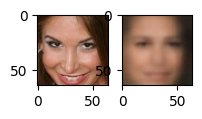

 14%|█▍        | 496/3434 [00:05<00:40, 73.13it/s]

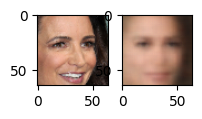

 29%|██▉       | 992/3434 [00:10<00:24, 101.55it/s]

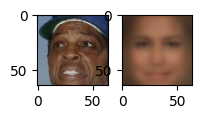

 43%|████▎     | 1491/3434 [00:16<00:18, 103.34it/s]

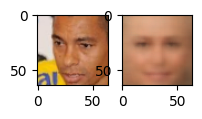

 58%|█████▊    | 1993/3434 [00:21<00:15, 94.22it/s]

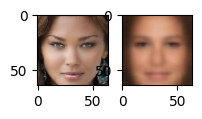

 73%|███████▎  | 2497/3434 [00:27<00:09, 104.03it/s]

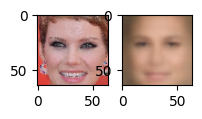

 87%|████████▋ | 2990/3434 [00:33<00:04, 98.45it/s]

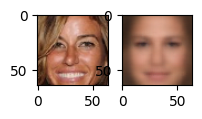

100%|██████████| 3434/3434 [00:37<00:00, 90.38it/s]


In [53]:
# we first define the hyperparameters
import IPython
batch_size = 32
learning_rate = 5e-4
latent_dim = 32
num_epochs = 6

# we then instantiate a new ss_model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# we now define the training operation

@tf.function # this command lets us turn a python function into a tensorflow computational graph
def ss_vae_train_step(x, y):
  '''
  we create a gradienttape object used to calculate gradient of the loss with respect to model parameters
  then we feed the input data to ss_vae model so it outputs the predictions and latent space
  and a reconstruction of the input
  we then call the ss_vae loss function
  then  we use gradienttape to compute gradient
  we then update the model parameters using gradient
  '''

  with tf.GradientTape() as tape:
    # we feed the input to ss_vae
    y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)

    # we call the ss_vae loss function
    loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, ss_vae.trainable_variables)
  optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size)
    # loss optimization
    loss = ss_vae_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, ss_vae)

reflection and analysis:
